In [1]:
import attack_kernelbased
import attack_fgsm
import attack_df
import attack_jsma
import attack_gen
import dataloader
import spatial

import torch
import torch.nn as nn
import numpy as np
import time
import onlinehd
import DNNmodels
import pickle
from sklearn.model_selection import train_test_split
import tqdm

In [2]:
X_train, X_test, y_train, y_test = dataloader.load(None, sklearn_dataset_name='EMNIST_Balanced')

classes = y_train.unique().size(0)
features = X_train.size(1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

/Users/sang-geon/Documents/UCI_BIASLab/kernel_adversarial/venv/lib/python3.8/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(torch.Size([98700, 784]),
 torch.Size([32900, 784]),
 torch.Size([98700]),
 torch.Size([32900]))

In [3]:
X_test = X_test[:100*classes]
y_test = y_test[:100*classes]

In [4]:
D = 4000
model = onlinehd.OnlineHD(classes, features, dim=D)
model = model.fit(X_train, y_train, bootstrap=1.0, lr=0.035, epochs=2, one_pass_fit=False)

yhat_train = model(X_train)
yhat_test = model(X_test)

acc = (y_train == yhat_train).float().mean()
acc_test = (y_test == yhat_test).float().mean()
print(acc, acc_test)

tensor(0.7747) tensor(0.7315)


In [5]:
with open('./onlinehd_emnist.pickle', 'bw') as f:
    pickle.dump(model, f)

In [6]:
with open('./onlinehd_emnist.pickle', 'br') as f:
    model = pickle.load(f)

In [7]:
model_cnn = DNNmodels.CNN(num_classes=classes)
model_cnn.load_state_dict(torch.load('./model_cnn_emnist.pt'))
model_cnn.eval()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1))
  (relu2): ReLU()
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=47, bias=True)
)

## Kernel based attack

In [8]:
# with complex encoding (FHRR)
for e in np.linspace(0.01, 0.1, 10):#[0.01, 0.03, 0.07, 0.1]:
    st = time.time()
    X_test_noised = attack_kernelbased.genAdversarialNoise(model, X_test, y_test, e)
    print(time.time() - st)
    
    yhat_test = model(X_test_noised)
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 4700/4700 [03:00<00:00, 26.09it/s]


182.64438033103943
0.01 0.007314892951399088 0.6685106158256531 0.7614893913269043


100%|██████████| 4700/4700 [02:59<00:00, 26.23it/s]


181.79089212417603
0.020000000000000004 0.014629784040153027 0.6004255414009094 0.7538297772407532


100%|██████████| 4700/4700 [02:57<00:00, 26.52it/s]


179.65178227424622
0.030000000000000006 0.0219446811825037 0.5257446765899658 0.745319128036499


100%|██████████| 4700/4700 [02:57<00:00, 26.51it/s]


179.74376893043518
0.04000000000000001 0.029259568080306053 0.4459574520587921 0.7344681024551392


100%|██████████| 4700/4700 [02:57<00:00, 26.53it/s]


179.64634013175964
0.05000000000000001 0.03657447174191475 0.3717021346092224 0.7225531935691833


100%|██████████| 4700/4700 [02:56<00:00, 26.57it/s]


179.3253300189972
0.06000000000000001 0.0438893623650074 0.295319139957428 0.7070212960243225


100%|██████████| 4700/4700 [02:57<00:00, 26.52it/s]


179.6640510559082
0.07 0.05120425671339035 0.22638298571109772 0.6887233853340149


100%|██████████| 4700/4700 [03:00<00:00, 26.05it/s]


182.85997700691223
0.08 0.058519136160612106 0.16319148242473602 0.6706383228302002


100%|██████████| 4700/4700 [03:00<00:00, 26.02it/s]


183.09364914894104
0.09000000000000001 0.06583405286073685 0.1129787266254425 0.6519148945808411


100%|██████████| 4700/4700 [03:00<00:00, 26.04it/s]


182.92898082733154
0.1 0.0731489434838295 0.07276595383882523 0.6291489601135254


## FGSM

### Normlized

100%|██████████| 4700/4700 [00:27<00:00, 172.43it/s]



FGSM Attack with epsilon = 0.01000 | Elapsed time: 27.260976249999885 seconds.
Accuracy: Before the attack -> 73.15%	|	After the attack -> 72.98%
mean of norm=0.010000004433095455


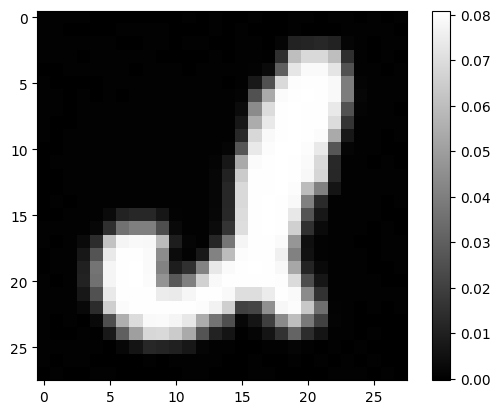

100%|██████████| 4700/4700 [00:27<00:00, 171.59it/s]



FGSM Attack with epsilon = 0.02000 | Elapsed time: 27.41805637499988 seconds.
Accuracy: Before the attack -> 73.15%	|	After the attack -> 72.89%
mean of norm=0.02000000886619091


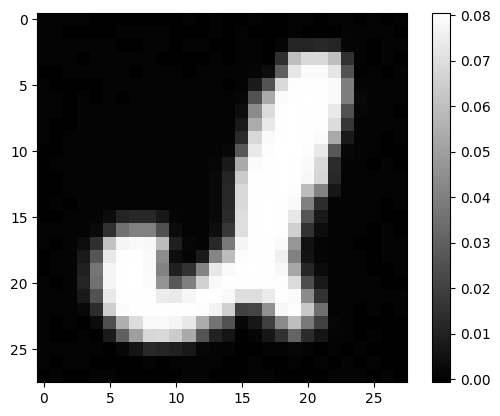

100%|██████████| 4700/4700 [00:28<00:00, 166.08it/s]



FGSM Attack with epsilon = 0.03000 | Elapsed time: 28.32839445899981 seconds.
Accuracy: Before the attack -> 73.15%	|	After the attack -> 72.81%
mean of norm=0.029999999329447746


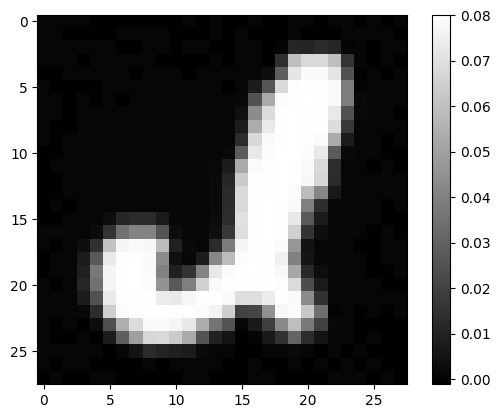

100%|██████████| 4700/4700 [00:28<00:00, 165.63it/s]



FGSM Attack with epsilon = 0.04000 | Elapsed time: 28.407549000000017 seconds.
Accuracy: Before the attack -> 73.15%	|	After the attack -> 72.47%
mean of norm=0.04000001773238182


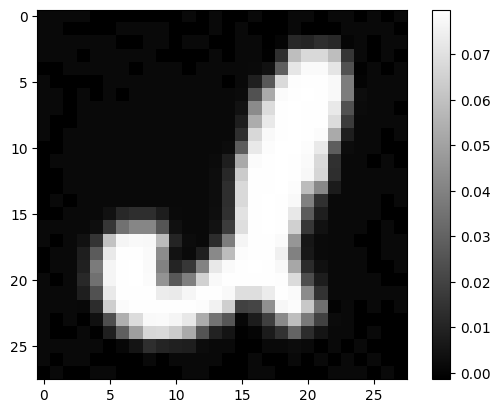

100%|██████████| 4700/4700 [00:26<00:00, 179.69it/s]



FGSM Attack with epsilon = 0.05000 | Elapsed time: 26.192765000000236 seconds.
Accuracy: Before the attack -> 73.15%	|	After the attack -> 72.45%
mean of norm=0.05000000074505806


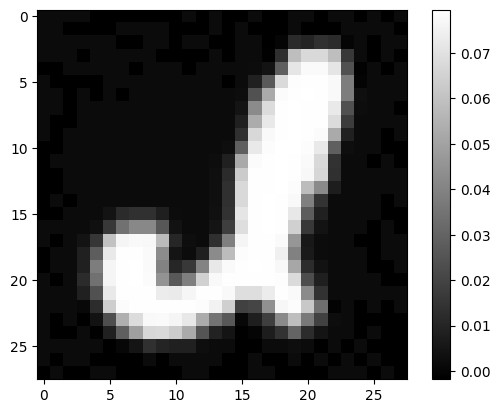

100%|██████████| 4700/4700 [00:26<00:00, 179.74it/s]



FGSM Attack with epsilon = 0.06000 | Elapsed time: 26.180311500000244 seconds.
Accuracy: Before the attack -> 73.15%	|	After the attack -> 72.36%
mean of norm=0.0599999725818634


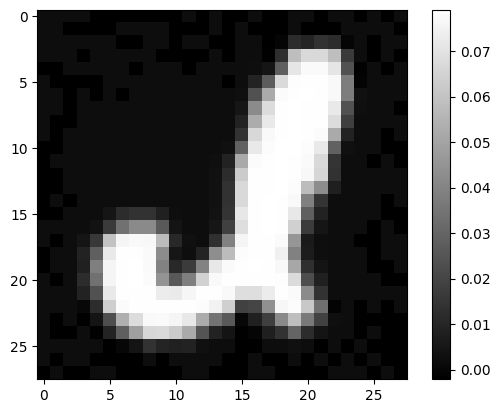

100%|██████████| 4700/4700 [00:26<00:00, 178.03it/s]



FGSM Attack with epsilon = 0.07000 | Elapsed time: 26.429880375000266 seconds.
Accuracy: Before the attack -> 73.15%	|	After the attack -> 72.04%
mean of norm=0.06999998539686203


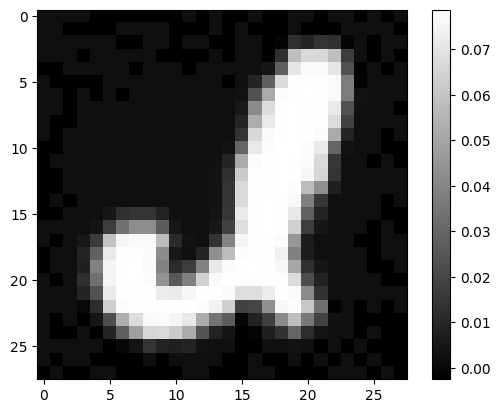

100%|██████████| 4700/4700 [00:26<00:00, 177.69it/s]



FGSM Attack with epsilon = 0.08000 | Elapsed time: 26.48558970899967 seconds.
Accuracy: Before the attack -> 73.15%	|	After the attack -> 71.81%
mean of norm=0.08000003546476364


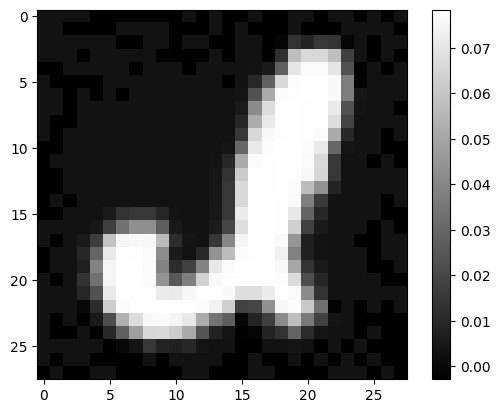

100%|██████████| 4700/4700 [00:26<00:00, 176.71it/s]



FGSM Attack with epsilon = 0.09000 | Elapsed time: 26.630618750000394 seconds.
Accuracy: Before the attack -> 73.15%	|	After the attack -> 71.45%
mean of norm=0.0899999812245369


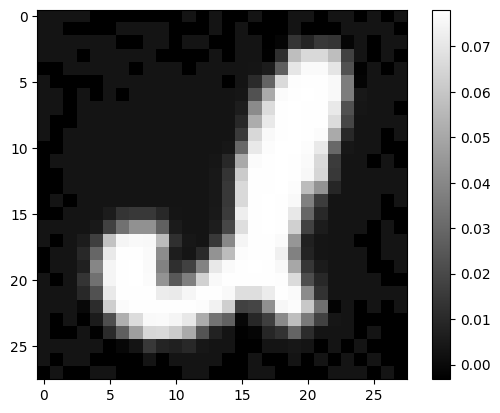

100%|██████████| 4700/4700 [00:26<00:00, 179.00it/s]



FGSM Attack with epsilon = 0.10000 | Elapsed time: 26.28878749999967 seconds.
Accuracy: Before the attack -> 73.15%	|	After the attack -> 71.19%
mean of norm=0.09999996423721313


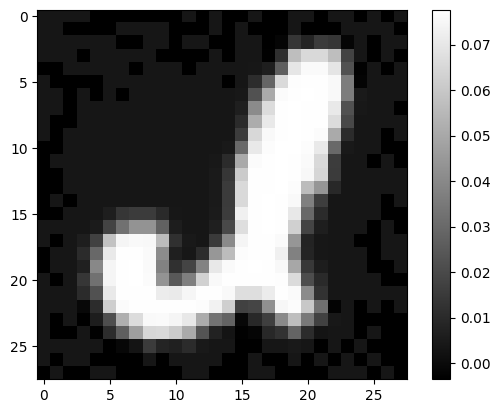

In [9]:
epsilons = np.linspace(0.01, 0.1, 10) # torch.Tensor([0.01, 0.03, 0.07, 0.1])
verbose = False
#criterion = nn.CosineEmbeddingLoss()
criterion = lambda output, model, label: (spatial.cos_cdist(output, model) - label).mean()
#criterion = lambda output, model, label: output.mean()
N_VAL_SAMPLES = X_test.data.shape[0]

attack_samples, acc_results = attack_fgsm.attack(
    model, X_train, X_test, y_test, epsilons, classes, criterion, N_VAL_SAMPLES, 'cpu')

In [10]:
for e, X_test_noised in zip(epsilons, attack_samples):
    yhat_test = model(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(e, distance, onlinehd_attacked_acc, cnn_attacked_acc)

0.01 0.010000004433095455 0.7297872304916382 0.7689361572265625
0.020000000000000004 0.02000000886619091 0.7289361953735352 0.769361674785614
0.030000000000000006 0.029999999329447746 0.7280851006507874 0.769361674785614
0.04000000000000001 0.04000001773238182 0.7246808409690857 0.7672340273857117
0.05000000000000001 0.05000000074505806 0.7244681119918823 0.7651063799858093
0.06000000000000001 0.0599999725818634 0.7238298058509827 0.7597872614860535
0.07 0.06999998539686203 0.720425546169281 0.7538297772407532
0.08 0.08000003546476364 0.7180851101875305 0.7493616938591003
0.09000000000000001 0.0899999812245369 0.7144680619239807 0.739787220954895
0.1 0.09999996423721313 0.7117021083831787 0.7293617129325867


## Deep Fool

In [11]:
for max_update in np.linspace(0.01, 0.2, 20):
    X_te_cln = X_test.clone().reshape(-1, 1, 784)
    Y_te_cln = y_test.clone()

    x_test_adv = torch.zeros(X_te_cln.shape)
    x_test_pert = torch.zeros(X_te_cln.shape[0], 28, 28)

    st = time.time()
    for i in tqdm.tqdm(range(X_test.shape[0])):
        x_test_adv[i], x_test_pert[i] = attack_df.deepfool(X_te_cln[i], model, epsilon=max_update)
    print(time.time() - st)
    
    X_test_noised = x_test_adv.reshape(-1, features)

    yhat_test = model(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(max_update, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 4700/4700 [10:40<00:00,  7.34it/s]


640.6541740894318
0.01 0.008491981774568558 0.7142553329467773 0.7644680738449097


100%|██████████| 4700/4700 [09:25<00:00,  8.31it/s]


565.3904268741608
0.02 0.016983963549137115 0.6800000071525574 0.757446825504303


100%|██████████| 4700/4700 [08:15<00:00,  9.48it/s]


495.6749498844147
0.03 0.02547594904899597 0.6263830065727234 0.7517021298408508


100%|██████████| 4700/4700 [07:01<00:00, 11.14it/s]


421.9646589756012
0.04 0.03396792709827423 0.5580850839614868 0.7446808218955994


100%|██████████| 4700/4700 [05:21<00:00, 14.63it/s]


321.20687794685364
0.05 0.042459916323423386 0.48638299107551575 0.7340425252914429


100%|██████████| 4700/4700 [04:31<00:00, 17.30it/s]


271.6284761428833
0.060000000000000005 0.05095190182328224 0.41255319118499756 0.7236170172691345


100%|██████████| 4700/4700 [03:39<00:00, 21.39it/s]


219.72746896743774
0.06999999999999999 0.0594438798725605 0.34574466943740845 0.707446813583374


100%|██████████| 4700/4700 [02:59<00:00, 26.19it/s]


179.4490339756012
0.08 0.06793585419654846 0.2887234091758728 0.6914893388748169


100%|██████████| 4700/4700 [02:35<00:00, 30.28it/s]


155.2338671684265
0.09 0.07642786204814911 0.24851064383983612 0.6742553114891052


100%|██████████| 4700/4700 [02:24<00:00, 32.52it/s]


144.54046416282654
0.09999999999999999 0.08491983264684677 0.2334042489528656 0.6544680595397949


100%|██████████| 4700/4700 [02:21<00:00, 33.32it/s]


141.06924176216125
0.11 0.09341182559728622 0.2282978743314743 0.6327659487724304


100%|██████████| 4700/4700 [02:20<00:00, 33.54it/s]


140.12831926345825
0.12 0.10190379619598389 0.22702127695083618 0.6138297915458679


100%|██████████| 4700/4700 [02:20<00:00, 33.43it/s]


140.59318327903748
0.13 0.11039576679468155 0.22680850327014923 0.5946808457374573


100%|██████████| 4700/4700 [02:19<00:00, 33.57it/s]


139.996572971344
0.14 0.118887759745121 0.22659574449062347 0.5714893341064453


100%|██████████| 4700/4700 [02:20<00:00, 33.50it/s]


140.2917459011078
0.15000000000000002 0.12737973034381866 0.22680850327014923 0.5534042716026306


100%|██████████| 4700/4700 [02:20<00:00, 33.45it/s]


140.51095294952393
0.16 0.13587170839309692 0.22680850327014923 0.5368084907531738


100%|██████████| 4700/4700 [02:20<00:00, 33.33it/s]


140.99545121192932
0.17 0.14436370134353638 0.22659574449062347 0.5180851221084595


100%|██████████| 4700/4700 [02:21<00:00, 33.33it/s]


141.00737285614014
0.18000000000000002 0.15285572409629822 0.22680850327014923 0.49787235260009766


100%|██████████| 4700/4700 [02:16<00:00, 34.55it/s]


136.0431079864502
0.19 0.16134768724441528 0.22680850327014923 0.4825531840324402


100%|██████████| 4700/4700 [02:15<00:00, 34.65it/s]


135.6248745918274
0.2 0.16983966529369354 0.22680850327014923 0.4672340452671051


In [12]:
X_te_cln = X_test.clone().reshape(-1, 1, 784)
Y_te_cln = y_test.clone()

x_test_adv = torch.zeros(X_te_cln.shape)
x_test_pert = torch.zeros(X_te_cln.shape[0], 28, 28)

for i in tqdm.tqdm(range(X_test.shape[0])):
    x_test_adv[i], x_test_pert[i] = attack_df.deepfool(X_te_cln[i], model, epsilon=None)

X_test_noised = x_test_adv.reshape(-1, features)

yhat_test = model(X_test_noised.reshape(-1, 28*28))
yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

print(None, distance, onlinehd_attacked_acc, cnn_attacked_acc)

100%|██████████| 4700/4700 [02:14<00:00, 34.89it/s]


None 0.10365879535675049 0.22617021203041077 0.5708510875701904


## Genetic Attack

In [13]:
alpha_lis = np.linspace(0.0001, 0.0015, 20) #[0.01, 0.03, 0.07, 0.1]
delta = 0.5
nData = len(alpha_lis)
model_accuracy_GA = np.zeros(nData)

x_test_samp = X_test.cpu()
y_test_samp = y_test.cpu()

for n in range(nData):
    alpha = alpha_lis[n]
    print(f"Alpha : {alpha}")

    st = time.time()
    x_test_GA, _ = attack_gen.make_GA(model, delta, alpha, x_test_samp, y_test_samp)
    print(time.time() - st)
    
    X_test_noised = x_test_GA.reshape(-1, features)

    yhat_test = model(X_test_noised.reshape(-1, 28*28))
    yhat_test_cnn = model_cnn(X_test_noised.reshape(-1, 1, 28, 28)).argmax(1)

    onlinehd_attacked_acc = (y_test == yhat_test).float().mean().item()
    cnn_attacked_acc = (y_test == yhat_test_cnn).float().mean().item()
    distance = (X_test_noised.reshape(-1, 28*28) - X_test).norm(dim=-1).mean().item()

    print(alpha, distance, onlinehd_attacked_acc, cnn_attacked_acc)

#model_accuracy_GA

Alpha : 0.0001


  0%|          | 1/1000 [00:06<1:44:40,  6.29s/it]